<h1>CS4618 Assignment, 2023</h1>
<h2>
    Ines Roman Gracia<br>
    123123969
</h2>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin

<h1>Read in and Check the Data</h1>

In [3]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv("dataset_reoffending.csv")

In [4]:
# The dimensions
df.shape

(25835, 53)

In [5]:
# The columns, their datatypes and whether there are nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25835 entries, 0 to 25834
Data columns (total 53 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    25835 non-null  int64  
 1   gender                                25835 non-null  object 
 2   race                                  25835 non-null  object 
 3   age                                   25835 non-null  object 
 4   address                               25835 non-null  int64  
 5   gang_affiliated                       22668 non-null  object 
 6   risk_score                            25360 non-null  float64
 7   supervision_level                     24115 non-null  object 
 8   education_level                       25835 non-null  object 
 9   dependents                            25835 non-null  object 
 10  offence                               22558 non-null  object 
 11  years_in_prison

In [6]:
features = ["id", "gender",	"race",	"age", "address", "gang_affiliated", "risk_score", "supervision_level", "education_level", "dependents", "offence", "years_in_prison", "felony_arrests", "misdemeanor_arrests", "violence_arrests", "property_arrests", "drug_arrests", "parole_violation_arrests", "domestic_violence_arrests", "gun_arrests", "felony_convictions", "misdemeanor_convictions", "violence_convictions", "property_convictions", "drug_convictions", "parole_violation_convictions", "domestic_violence_convictions", "gun_convictions", "parole_revocations", "probation_revocations", "mh_sa_programme", "cs_programme", "other_condition", "electronic_monitoring_violations", "instruction_following_violations", "failure_to_report_violations", "moving_without_permission_violations", "num_delinquency_reports", "num_program_attendances", "num_unexcused_absences", "num_residence_changes", "days_between_drug_tests", "marijuana_positive_tests", "cocaine_positive_tests", "meth_positive_tests", "other_positive_tests", "days_employed", "jobs_per_year", "employment_exempt", "reoffended_in_year_1", "reoffended_in_year_2", "reoffended_in_year_3"]

In [7]:
for feature in features:
    print(feature, df[feature].unique())

id [    1     2     3 ... 26759 26760 26761]
gender ['M' 'F']
race ['black' 'white']
age ['43-47' '33-37' '48 or older' '38-42' '18-22' '23-27' '28-32']
address [16 24 17 18  5  3 12 14 23  6  2 25 10 21  4  9 19 20 11 22  1 15  8 13
  7]
gang_affiliated [False nan True]
risk_score [ 3.  6.  7.  4.  5.  2.  1. 10.  9.  8. nan]
supervision_level ['Standard' 'Specialized' 'High' nan]
education_level ['At least some college' 'Less than HS diploma' 'High School Diploma']
dependents ['3 or more' '1' '0' '2']
offence ['Drug' 'Violent/Non-Sex' 'Property' nan 'Other' 'Violent/Sex']
years_in_prison ['More than 3 years' '1-2 years' 'Less than 1 year'
 'Greater than 2 to 3 years']
felony_arrests ['6' '7' '8' '4' '10 or more' '3' '9' '2' '5' '1' '0']
misdemeanor_arrests ['6 or more' '4' '0' '1' '3' '5' '2']
violence_arrests ['1' '3 or more' '0' '2']
property_arrests ['3' '0' '2' '5 or more' '1' '4']
drug_arrests ['3' '2' '1' '0' '5 or more' '4']
parole_violation_arrests ['4' '5 or more' '3' '0' '1

<h1>Data Cleaning</h1>
<p>We delete the columns containing data on whether each person will reoffend in the first, second, or third year since these columns, as a whole, have the same value as the target value, which is the value we want to determine from the data. Therefore, we need to eliminate those that directly provide it:</p>

In [8]:
df = df.drop(['reoffended_in_year_1', 'reoffended_in_year_2', 'reoffended_in_year_3'], axis=1)
for column in ['reoffended_in_year_1', 'reoffended_in_year_2', 'reoffended_in_year_3']:
    features.remove(column)

Some objects to numeric values:

In [9]:
# There's a mix between numeric and nominal values in some columns, let's clean the data and transform them into numeric
# Replace 'or more' and convert to integers

df['dependents'] = df['dependents'].replace(' or more', '', regex=True).astype(int)

df['years_in_prison'] = df['years_in_prison'].map({'Less than 1 year': 0, '1-2 years': 1, 'Greater than 2 to 3 years': 2, 'More than 3 years': 3}).astype(int)

df['felony_arrests'] = df['felony_arrests'].replace(' or more', '', regex=True).astype(int)

df['misdemeanor_arrests'] = df['misdemeanor_arrests'].replace(' or more', '', regex=True).astype(int)

df['violence_arrests'] = df['violence_arrests'].replace(' or more', '', regex=True).astype(int)

df['property_arrests'] = df['property_arrests'].replace(' or more', '', regex=True).astype(int)

df['drug_arrests'] = df['drug_arrests'].replace(' or more', '', regex=True).astype(int)

df['parole_violation_arrests'] = df['parole_violation_arrests'].replace(' or more', '', regex=True).astype(int)

df['felony_convictions'] = df['felony_convictions'].replace(' or more', '', regex=True).astype(int)

df['misdemeanor_convictions'] = df['misdemeanor_convictions'].replace(' or more', '', regex=True).astype(int)

df['violence_convictions'] = df['violence_convictions'].replace(' or more', '', regex=True).astype(int)

df['property_convictions'] = df['property_convictions'].replace(' or more', '', regex=True).astype(int)

df['drug_convictions'] = df['drug_convictions'].replace(' or more', '', regex=True).astype(int)

df['num_delinquency_reports'] = df['num_delinquency_reports'].replace(' or more', '', regex=True).astype(int)

df['num_program_attendances'] = df['num_program_attendances'].replace(' or more', '', regex=True).astype(int)

df['num_unexcused_absences'] = df['num_unexcused_absences'].replace(' or more', '', regex=True).astype(int)

df['num_residence_changes'] = df['num_residence_changes'].replace(' or more', '', regex=True).astype(int)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25835 entries, 0 to 25834
Data columns (total 50 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    25835 non-null  int64  
 1   gender                                25835 non-null  object 
 2   race                                  25835 non-null  object 
 3   age                                   25835 non-null  object 
 4   address                               25835 non-null  int64  
 5   gang_affiliated                       22668 non-null  object 
 6   risk_score                            25360 non-null  float64
 7   supervision_level                     24115 non-null  object 
 8   education_level                       25835 non-null  object 
 9   dependents                            25835 non-null  int64  
 10  offence                               22558 non-null  object 
 11  years_in_prison

In [11]:
numeric_features = ["address", "risk_score", "dependents", "years_in_prison", "felony_arrests", "misdemeanor_arrests", "violence_arrests", "property_arrests", "drug_arrests", "parole_violation_arrests", "felony_convictions", "misdemeanor_convictions", "property_convictions", "drug_convictions", "num_delinquency_reports", "num_program_attendances", "num_unexcused_absences", "num_residence_changes", "days_between_drug_tests", "marijuana_positive_tests", "cocaine_positive_tests", "meth_positive_tests", "other_positive_tests", "days_employed", "jobs_per_year"]
binary_features = ["gang_affiliated", "domestic_violence_arrests", "gun_arrests", "violence_convictions", "parole_violation_convictions", "domestic_violence_convictions", "gun_convictions", "parole_revocations", "probation_revocations", "mh_sa_programme", "cs_programme", "other_condition", "electronic_monitoring_violations", "instruction_following_violations", "failure_to_report_violations", "moving_without_permission_violations", "employment_exempt"]
nominal_features = ["gender", "race", "age", "supervision_level", "education_level", "offence"]

<p>Data cleaning is challenging due to the large number of columns, and the fact that most of the data falls within a predetermined value range from which they cannot deviate. The decision has been made not to delete any rows, even in cases where some data is missing. This is because there are a significant number of columns that can still contribute to predicting the target value of a row, and the number of columns with missing values is relatively small compared to the overall dataset size.</p>

<h1>Create a Test Set</h1>
<ul>
    <li>Split off a test set.</li>
    <li>Don't look at it: everything we do until our final error estimation will be done on the rest of
        the dataset.
    </li>
</ul>

In [12]:
# Split off the test set: 20% of the dataset. Note the stratification
dev_df, test_df = train_test_split(df, train_size=0.8, stratify=df["reoffended_within_3_years"], random_state=2)

<h1>Dataset Exploration</h1>
<p>Due to the dataset's size, it's impossible to look at all the data in the same scatter matrix, so we will examine the data in related sets, always including the target value. In this case, we first look at all the data related to drugs:</p>

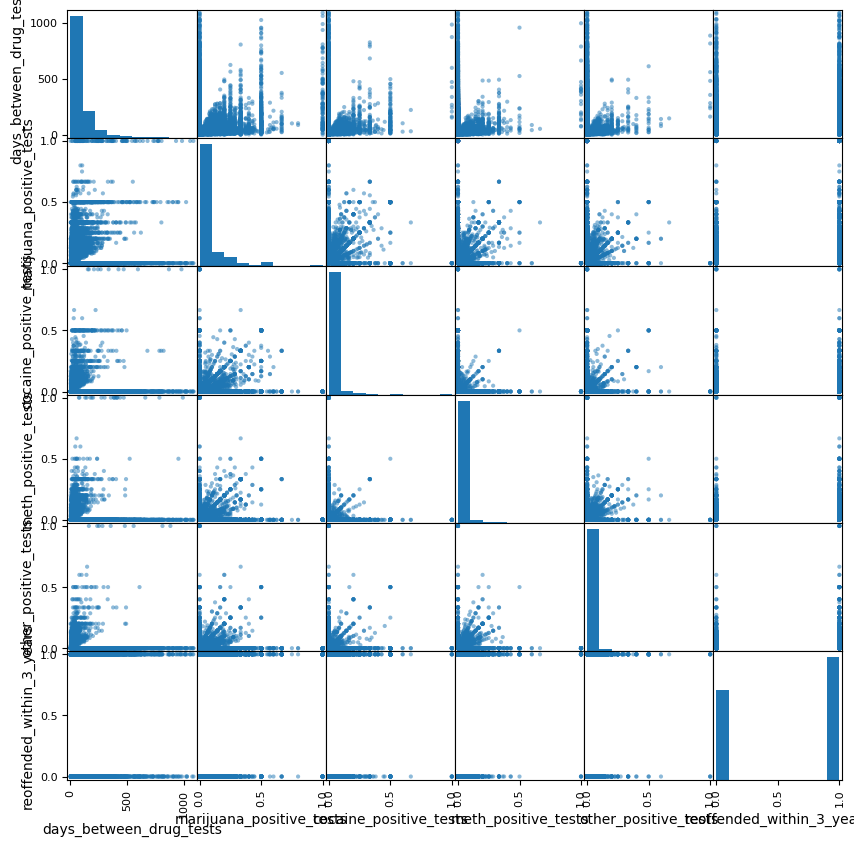

In [13]:
# It can be good to do this on a copy of the dataset (excluding the test set, of course)
copy_df = dev_df.copy()

# Convert boolean columns to numeric (True: 1, False: 0)
copy_df[copy_df.select_dtypes(include=['bool']).columns] = copy_df.select_dtypes(include=['bool']).astype(int)

# Create scatter matrix
m = scatter_matrix(copy_df[["days_between_drug_tests", "marijuana_positive_tests", "cocaine_positive_tests", "meth_positive_tests", "other_positive_tests", "reoffended_within_3_years"]], figsize=(10, 10))
plt.show()

<p>Now, we examine the data related to jobs:</p>

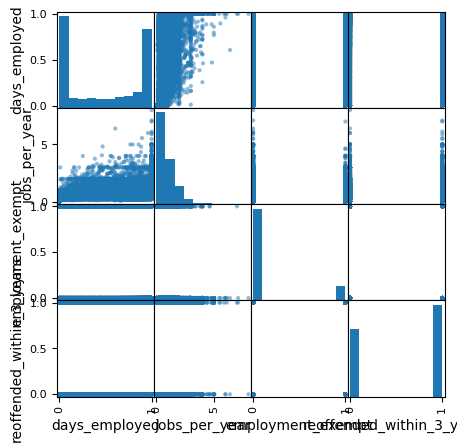

In [14]:
# Create scatter matrix
m = scatter_matrix(copy_df[["days_employed", "jobs_per_year", "employment_exempt", "reoffended_within_3_years"]], figsize=(5, 5))
plt.show()

<p>It's difficult to observe anything in these graphs when all values are discrete. Heatmaps are likely to be much more helpful; let's switch to them. First, let's look at the general features:</p>

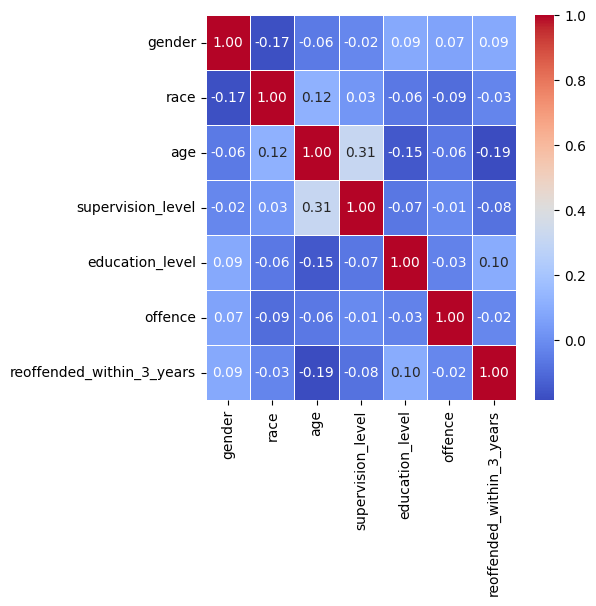

In [15]:
# Convert non-numeric values to numeric (example: label encoding for categorical)
copy_df[nominal_features] = copy_df[nominal_features].apply(LabelEncoder().fit_transform)

correlation_matrix = copy_df[nominal_features + ["reoffended_within_3_years"]].corr()

# Create a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

<p>Now, let's take a look at the data regarding drugs.</p>

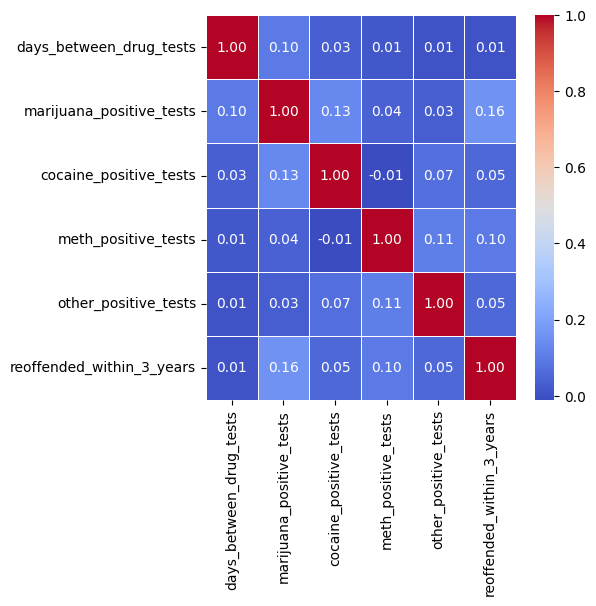

In [16]:
correlation_matrix = copy_df[["days_between_drug_tests", "marijuana_positive_tests", "cocaine_positive_tests", "meth_positive_tests", "other_positive_tests", "reoffended_within_3_years"]].corr()

# Create a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

<p>Now, let's explore the data related to employment:</p>

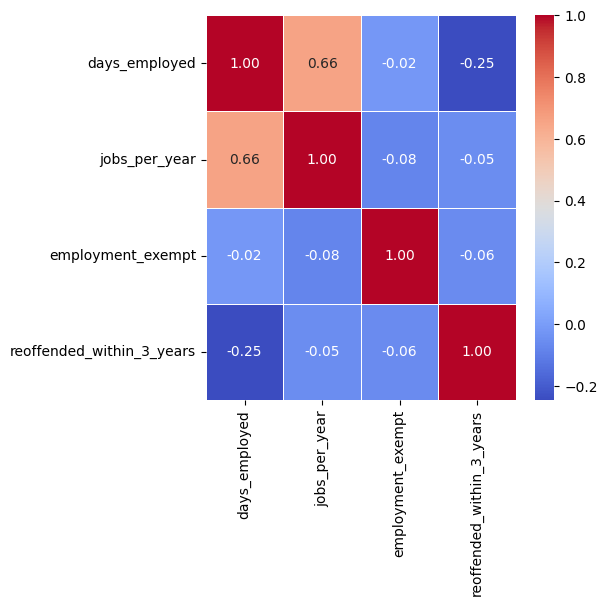

In [17]:
correlation_matrix = copy_df[["days_employed", "jobs_per_year", "employment_exempt", "reoffended_within_3_years"]].corr()

# Create a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

<p>And finally, let's examine the remaining data.</p>

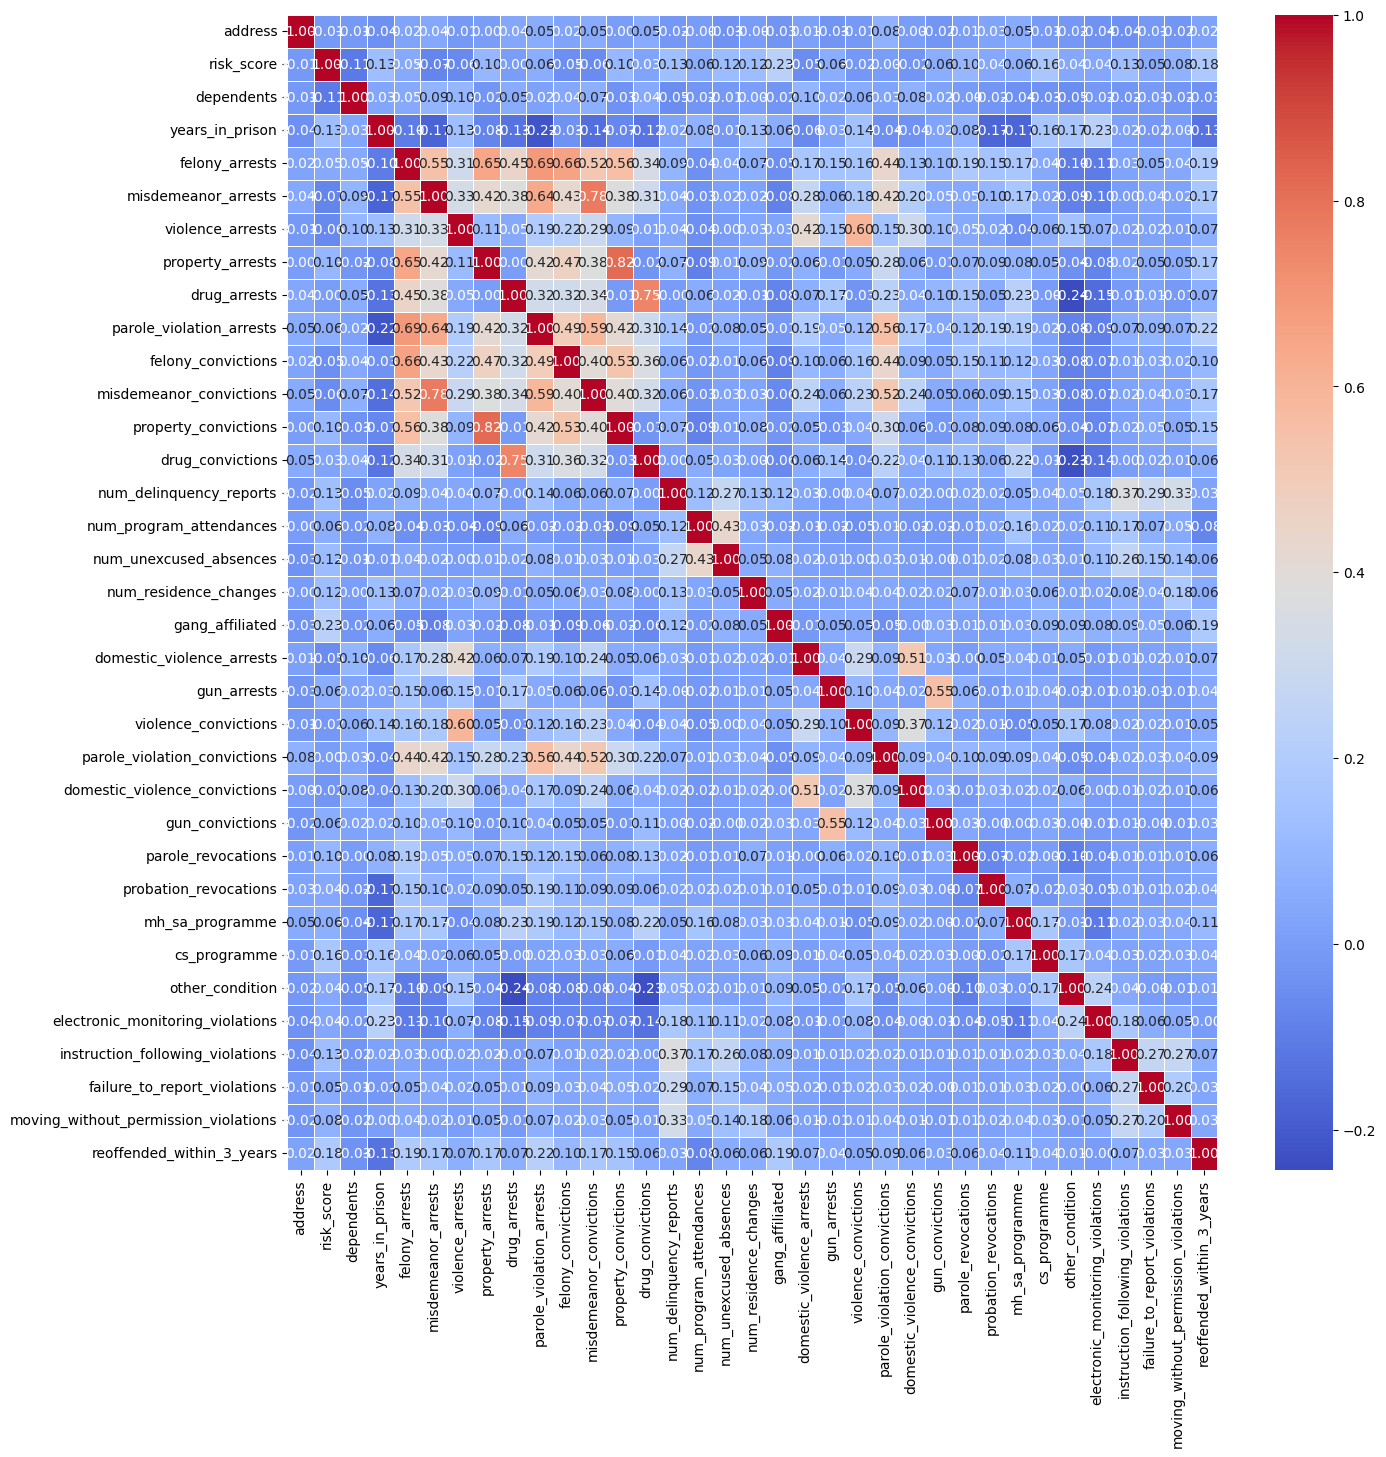

In [18]:
mas_features = ["address", "risk_score", "dependents", "years_in_prison", "felony_arrests", "misdemeanor_arrests", "violence_arrests", "property_arrests", "drug_arrests", "parole_violation_arrests", "felony_convictions", "misdemeanor_convictions", "property_convictions", "drug_convictions", "num_delinquency_reports", "num_program_attendances", "num_unexcused_absences", "num_residence_changes", "gang_affiliated", "domestic_violence_arrests", "gun_arrests", "violence_convictions", "parole_violation_convictions", "domestic_violence_convictions", "gun_convictions", "parole_revocations", "probation_revocations", "mh_sa_programme", "cs_programme", "other_condition", "electronic_monitoring_violations", "instruction_following_violations", "failure_to_report_violations", "moving_without_permission_violations"]
correlation_matrix = copy_df[mas_features + ["reoffended_within_3_years"]].corr()

# Create a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

<p>As we have observed in the graphs and heatmaps, there are no decisive factors when it comes to determining whether a prisoner will reoffend in less than three years. However, it is noticeable that some factors carry more weight, while the majority contribute very little.</p>

<h1>Dataset Preparation</h1>
<p>It has been quite challenging to find an additional feature that significantly improves the validation error, and the improvement isn't substantial either. This can be attributed to the dataset's large size and the limited decisive impact that features have on the target value.</p>

In [19]:
class InsertFeature(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["feature"] = (
                X["risk_score"] * 
                (X["felony_arrests"] + X["misdemeanor_arrests"] + X["parole_violation_arrests"]) *
                (X["felony_convictions"] + X["misdemeanor_convictions"])
            )
            
        return X


<p>No rows have been deleted from the dataset, and instead, it has been decided to impute the mean for missing numerical data and the most frequent values for boolean and nominal data:</p>

In [20]:
# Create the preprocessor
preprocessor = ColumnTransformer([
        ("num", Pipeline([("feature", InsertFeature()),
                        ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                        ("scaler", StandardScaler())]), 
                numeric_features),
        ("binary", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                            ("scaler", StandardScaler())]), 
                binary_features),
        ("nom", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")), 
                          ("binarizer", OneHotEncoder(handle_unknown="ignore"))]), 
                nominal_features)],
        remainder="passthrough")

<h1>Model Selection</h1>

In [21]:
# Extract the features but leave as a DataFrame
dev_X = dev_df[features]
test_X = test_df[features]

# Target values, encoded and converted to a 1D numpy array
label_encoder = LabelEncoder()
label_encoder.fit(df["reoffended_within_3_years"])
dev_y = label_encoder.transform(dev_df["reoffended_within_3_years"])
test_y = label_encoder.transform(test_df["reoffended_within_3_years"])

In [22]:
# Let's see how a majority-class classifier performs.
# This is our baseline. We need to do better than this!

maj = DummyClassifier()
maj.fit(dev_X, dev_y)
accuracy_score(test_y, maj.predict(test_X))

0.5769305206115735

In [23]:
# In the next cell, note the use of scoring="accuracy".
# And note that cv=10 is automatically stratified k-fold cross-validation.

# We'll just try kNN and LogisticRegression.
knn = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", KNeighborsClassifier())])

# Create a dictionary of hyperparameters for kNN
knn_param_grid = {"predictor__n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                 "preprocessor__num__feature__insert": [True, False]}


# Create the grid search object which will find the best hyperparameter values based on validation error
knn_gs = GridSearchCV(knn, knn_param_grid, scoring="accuracy", cv=10, refit=True)

# Run grid search by calling fit. It will also re-train on train+validation using the best parameters.
knn_gs.fit(dev_X, dev_y)

# Let's see how well we did
knn_gs.best_params_, knn_gs.best_score_

({'predictor__n_neighbors': 9, 'preprocessor__num__feature__insert': False},
 0.5432541795635186)

<p>The performance of the KNN model is disastrous, even falling below that of the majority-class classifier. Consequently, it can be definitively ruled out as a viable option.</p>

In [24]:
# Create a pipeline that combines the preprocessor with logistic regression
logistic = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", LogisticRegression(max_iter=1000))])

logistic_param_grid = {"preprocessor__num__feature__insert": [True, False]}

logistic_gs = GridSearchCV(logistic, logistic_param_grid, scoring="accuracy", cv=10, refit=True)

logistic_gs.fit(dev_X, dev_y)

# Let's see how well we did
logistic_gs.best_params_, logistic_gs.best_score_

({'preprocessor__num__feature__insert': True}, 0.7072286766975254)

In [25]:
# Create a pipeline that combines the preprocessor with ridge logistic regression
ridge_logistic = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", LogisticRegression(penalty="l2", max_iter=1000))])

ridge_logistic_param_grid = {"predictor__C": [0.1, 0.3, 0.5],
                    "preprocessor__num__feature__insert": [True, False]}

ridge_logistic_gs = GridSearchCV(ridge_logistic, ridge_logistic_param_grid, scoring="accuracy", cv=10, refit=True)

ridge_logistic_gs.fit(dev_X, dev_y)

# Let's see how well we did
ridge_logistic_gs.best_params_, ridge_logistic_gs.best_score_

({'predictor__C': 0.5, 'preprocessor__num__feature__insert': True},
 0.7106634426293233)

<h1>Evaluate on the Test Set</h1>
<p>The model that has achieved the best validation error is Ridge Regression with c=0.1. Therefore, we can now train the dataset with this model and calculate the test error:</p>

In [26]:
# Re-train Ridge Logistic Regression on train+validation and test on the test set
ridge_logistic = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", LogisticRegression(penalty="l2", C=0.1, max_iter=1000))
])
ridge_logistic.fit(dev_X, dev_y)

accuracy_score(test_y, ridge_logistic.predict(test_X))

0.7089220050319335